In [7]:
%matplotlib inline

In [8]:
import numpy as np
import astropy
from astropy.table import Table 
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [9]:
import warnings
warnings.filterwarnings("ignore")

# preamble 

In [10]:
def scatter_binning(x, y, nxbins=10, ax=None, title=None): 
    xs = np.linspace(np.min(x), np.max(x), nxbins)
    xbbins = [(xs[i], xs[i+1]) for i in range(len(xs)-1)]
    
    masks = [((xbbin[0] < x) & ( x < xbbin[1])) for xbbin in xbbins]
    binned_x = [x[mask] for mask in masks]
    binned_y = [y[mask] for mask in masks]
    
    xmeds = [np.median(xbin) for xbin in binned_x]
    ymeds = [np.median(ybin) for ybin in binned_y]
    
    xqs = np.array([[xmed - np.quantile(xbin, 0.25), np.quantile(xbin,0.75) - xmed] for (xmed,xbin) in zip(xmeds,binned_x)]).T
    yqs = np.array([[ymed - np.quantile(ybin, 0.25), np.quantile(ybin,0.75) - ymed] for (ymed,ybin) in zip(ymeds,binned_y)]).T
    
    if ax is None:
        plt.errorbar(xmeds, ymeds, xerr=xqs, yerr=yqs, fmt='ro--', capsize=10)
    else: 
        ax.errorbar(xmeds, ymeds, xerr=xqs, yerr=yqs, fmt='ro--', capsize=10)
        
    if title is not None: 
        ax.set_title(title)

In [11]:
#functions I need to define myself. 
cvir = lambda cat: cat['rvir'] / cat['rs']
phi_l = lambda cat: np.arccos(
    ((cat['A[x]']*cat['Jx'] + cat['A[y]']*cat['Jy'] + cat['A[z]']*cat['Jz'])
     /
    (np.sqrt(cat['A[x]']**2 + cat['A[y]']**2 + cat['A[z]']**2)*np.sqrt(cat['Jx']**2 + cat['Jy']**2 + cat['Jz']**2) )
    )
)
q = lambda cat: (1/2)*(cat['b_to_a'] + cat['c_to_a']);

In [12]:
#information about catalogue (https://www.cosmosim.org/cms/simulations/bolshoi/)
particle_mass = 1.35e8
total_particles = 2048**3 
box_size = 250 #Mpc/h

# read

In [13]:
from astropy.io import ascii

In [14]:
filename = '../data/hlist_1.00109.csv'

In [15]:
#100 Mb chunks of maximum memory in each iteration. 
#this returns a generator. 
tbls = ascii.read(filename, format='csv', guess=False,
                 fast_reader={'chunk_size': 100 * 1000000, 'chunk_generator': True})

In [16]:
#params we actually care about and we include in our table. 
params = ['mvir', 'cvir' , 'T/|U|', 'Xoff', 'Voff', 'Spin', 'q', 'phi_l', 'Acc_Rate_Inst',
          'Acc_Rate_1*Tdyn','scale_of_last_MM']


In [17]:
ftbls = [] 
for i, tbl in enumerate(tbls): 
    tbl.add_column(cvir(tbl), name='cvir')
    tbl.add_column(phi_l(tbl), name='phi_l')
    tbl.add_column(q(tbl), name='q')
    
    ftbls.append(tbl[params])
    if i%10 ==0: 
        print(i)

ftbl = astropy.table.vstack(ftbls)

0
10
20
30
40
50
60
70
80
90
100
110


In [19]:
#only look at things that have at least 1000 particles as several authors suggest. 
#others might be too noisy. 
cat = ftbl[ (np.log10(ftbl['mvir']) > 12) & 
          (ftbl['Spin'] != 0) &
          (ftbl['q'] !=0)]

# histograms

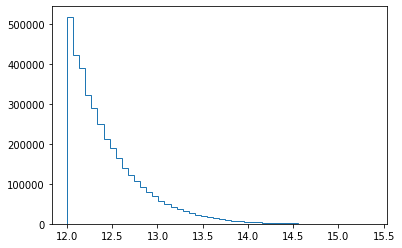

In [12]:
#mass
plt.hist(np.log10(cat['mvir']), bins=50, histtype='step');

mean, median, and std of:
mvir: 12.442320289529063 12.320769228338687 0.4103176389502013
cvir: 0.9133737839256427 0.932343900787439 0.25277211212274786
T/|U|: -0.23609573291005198 -0.24733705687902802 0.05584644261507784
Xoff: 1.2328829707719822 1.2259783034802667 0.29026864761353943
Voff: 1.2690550248604966 1.2633993313340022 0.40227738396152013
Spin: -1.458978274149478 -1.4386600585410987 0.24921072416734513
q: -0.19659842454098173 -0.17130788696810345 0.11086341495671925
phi_l: 0.16261497538436648 0.19609635636261302 0.1903849633792415


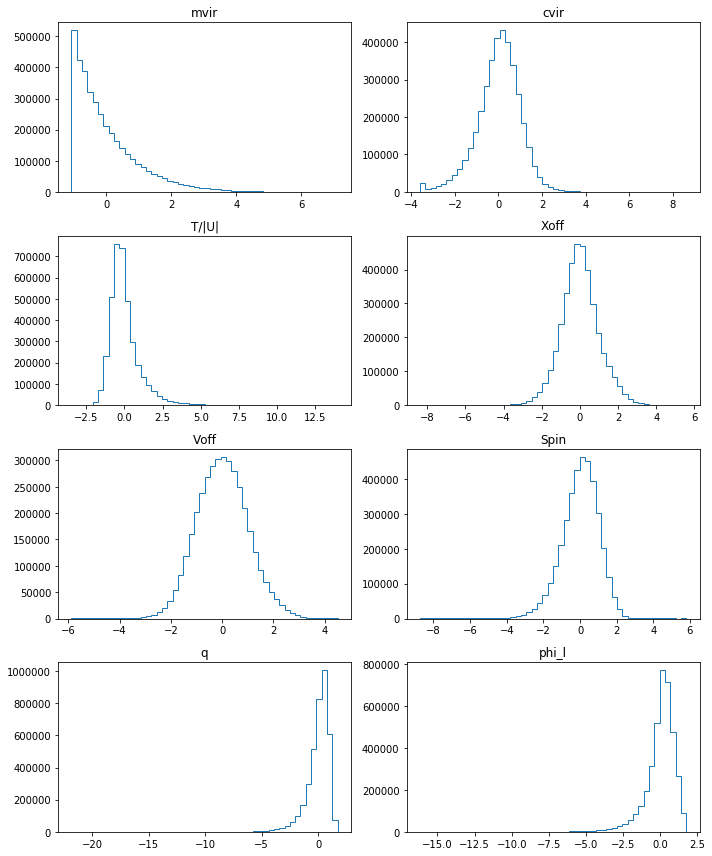

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(10,12))
params = ['mvir', 'cvir' , 'T/|U|', 'Xoff', 'Voff', 'Spin', 'q', 'phi_l']
print('mean, median, and std of:')
for param, ax in zip(params, axs.flatten()): 
    x = np.log10(cat[param]) 
    px = (x - np.mean(x))/ np.std(x)
    ax.set_title(param)
    ax.hist(px, histtype='step', bins=50)
    print(f'{param}:', np.mean(x), np.median(x), np.std(x))

fig.tight_layout() 

# Vanilla Scatters and Contours

correlation: 0.2222424401086844


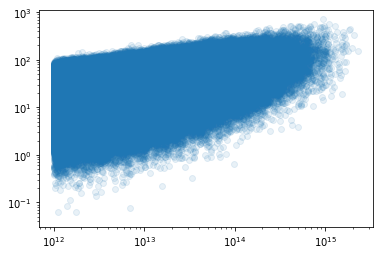

In [12]:
#all masses in catalogue
plt.scatter(cat['mvir'], cat['Xoff'], alpha=0.1)
plt.xscale('log')
plt.yscale('log')
print("correlation:", spearmanr(cat['mvir'], cat['Xoff'])[0])

([<matplotlib.lines.Line2D at 0x2b6adf754978>],
 <matplotlib.contour.QuadContourSet at 0x2b6adf754860>)

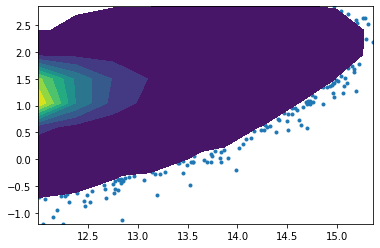

In [13]:
from astroML.plotting import scatter_contour
scatter_contour(np.log10(cat['mvir']), np.log10(cat['Xoff']), filled_contour=True, threshold=100, levels=10)

# correlations

In [ ]:
params = ['mvir', 'cvir' , 'T/|U|', 'Xoff', 'Voff', 'Spin', 'q', 'phi_l']

In [60]:
#prettier version. 
corrs = np.zeros((len(params), len(params)))
for i,param1 in enumerate(params): 
    for j,param2 in enumerate(params):
        corr, p = spearmanr(cat[param1], cat[param2])
        corrs[i,j] = corr

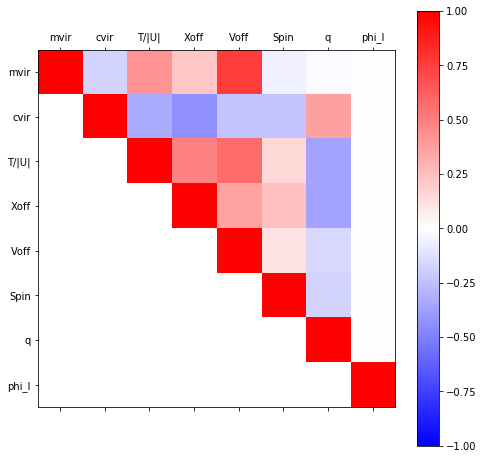

In [61]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
mask =  np.tri(corrs.shape[0], k=-1)
A = np.ma.array(corrs, mask=mask)
im = ax.matshow(A,cmap='bwr',vmin=-1, vmax=1)
plt.colorbar(im, ax = ax)
ax.set_xticklabels(['']+params);
ax.set_yticklabels(['']+params);

In [99]:
#print by hand. 
np.set_printoptions(threshold=100)
print(params)
corrs

['mvir', 'cvir', 'Spin', 'q', 'phi_l', 'Xoff', 'T/|U|']


array([[ 1.00000000e+00, -1.75523511e-01,  4.24186949e-01,
         2.22244956e-01,  7.64995259e-01, -6.18789026e-02,
        -2.24490578e-02,  3.67020469e-05],
       [-1.75523511e-01,  1.00000000e+00, -3.21983725e-01,
        -4.36992183e-01, -2.31489169e-01, -2.33150932e-01,
         3.72361875e-01, -1.41476538e-04],
       [ 4.24186949e-01, -3.21983725e-01,  1.00000000e+00,
         4.85937303e-01,  5.76096661e-01,  1.55082099e-01,
        -3.58415604e-01, -1.04685226e-04],
       [ 2.22244956e-01, -4.36992183e-01,  4.85937303e-01,
         1.00000000e+00,  3.65609324e-01,  2.43946891e-01,
        -3.52620598e-01, -9.49937762e-05],
       [ 7.64995259e-01, -2.31489169e-01,  5.76096661e-01,
         3.65609324e-01,  1.00000000e+00,  1.14407555e-01,
        -1.52727061e-01, -1.99328950e-04],
       [-6.18789026e-02, -2.33150932e-01,  1.55082099e-01,
         2.43946891e-01,  1.14407555e-01,  1.00000000e+00,
        -1.77633394e-01,  5.64504122e-05],
       [-2.24490578e-02,  3.723618

## Correlations between parameters, graphically

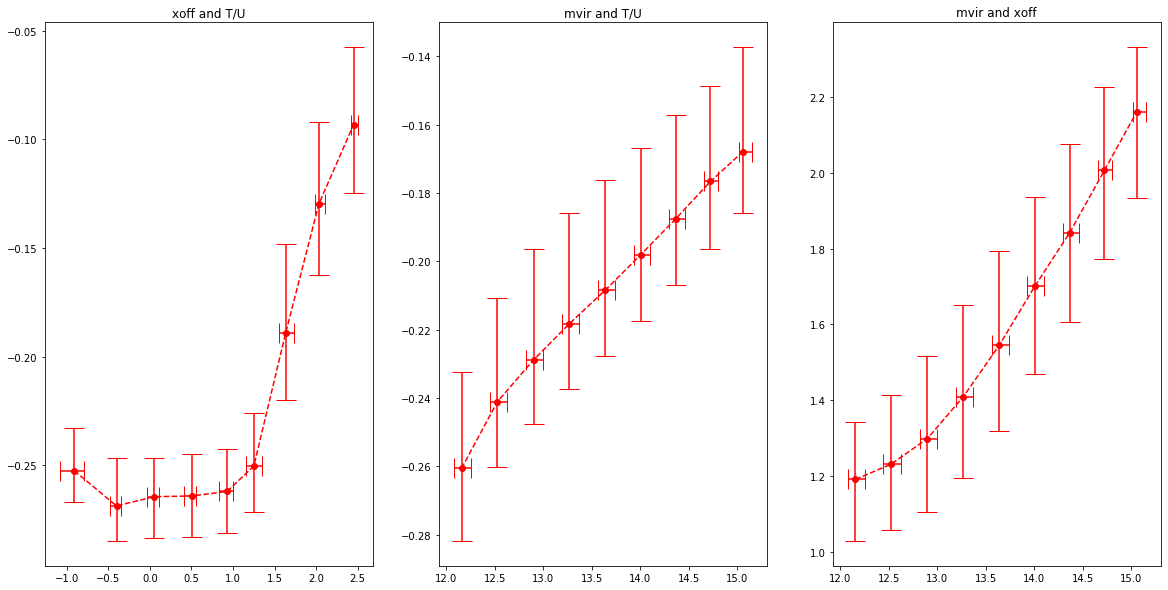

In [77]:
fig, axs = plt.subplots(1,3, figsize=(20,10))

scatter_binning(np.log10(cat['Xoff']), np.log10(cat['T/|U|']), nxbins=10, ax=axs[0], title='xoff and T/U')

scatter_binning(np.log10(cat['mvir']), np.log10(cat['T/|U|']), nxbins=10, ax=axs[1], title='mvir and T/U')

scatter_binning(np.log10(cat['mvir']), np.log10(cat['Xoff']), nxbins=10, ax=axs[2], title='mvir and xoff')


# PCA 

In [78]:
from sklearn.decomposition import PCA

In [79]:
params = ['mvir', 'cvir','Spin', 'q','phi_l', 'Xoff', 'T/|U|'
         ]

In [80]:
pca = PCA(n_components=4)

In [81]:
#normalize and take log.
#cuts on mass >= 12 once we get z= 0 catalogue and different fixed mass regimes too.  
# remove extreme outliers too. 
X = np.zeros((len(params), len(cat['mvir'])))
for i, param in enumerate(params): 
    x = np.log10(cat[param])
    px = (x - np.mean(x))/ np.std(x)
    X[i] = px 
    

In [85]:
pca.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [88]:
np.set_printoptions(threshold=50)
print(params)
print('singular values:', pca.singular_values_)
print('explained variance ratio:', pca.explained_variance_ratio_)  
print('components \n ', pca.components_)

['mvir', 'cvir', 'Spin', 'q', 'phi_l', 'Xoff', 'T/|U|']
singular values: [3081.55348112 2070.16598156 1929.0333174  1694.26214517]
explained variance ratio: [0.36195806 0.16335377 0.14183986 0.1094158 ]
components 
  [[ 0.25606243 -0.45008324  0.24390843 -0.46015147  0.04808422  0.50791403
   0.44759094]
 [ 0.66746691  0.16125609 -0.60903099  0.19212952 -0.23274213  0.07853374
   0.24559205]
 [-0.2126435  -0.11469082  0.05424395 -0.10650889 -0.96184821  0.01355982
  -0.04479243]
 [-0.39020568 -0.25759937 -0.72542735 -0.47783302  0.12975934 -0.08974518
  -0.04383112]]


# dynamical comparisons 

Useful to compare to the Power et al. 2011 paper

In [69]:
params = ['mvir', 'cvir' , 'T/|U|', 'Xoff', 'Voff', 'Spin', 'q', 'phi_l', 'Acc_Rate_Inst',
          'Acc_Rate_1*Tdyn','Acc_Rate_2*Tdyn']

Text(0.5, 1.0, 'mass and concentration')

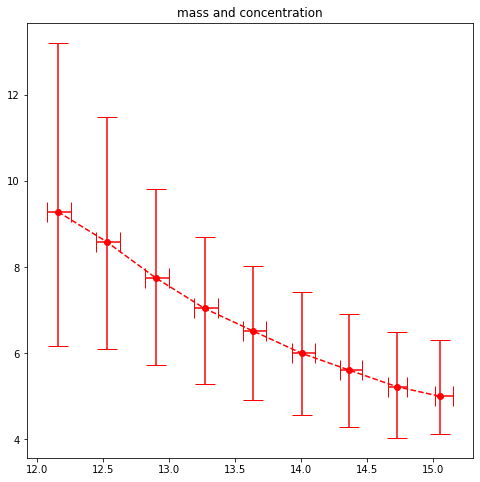

In [84]:
#not sure what Halfmass_Scale corresponds to but maybe inverse of (1+zform)^(-1)? 
fig, ax = plt.subplots(1,1,figsize=(8,8))
scatter_binning(np.log10(cat['mvir']), cat['cvir'], ax = ax, title='mass and concentration')
plt.title('mass and concentration')

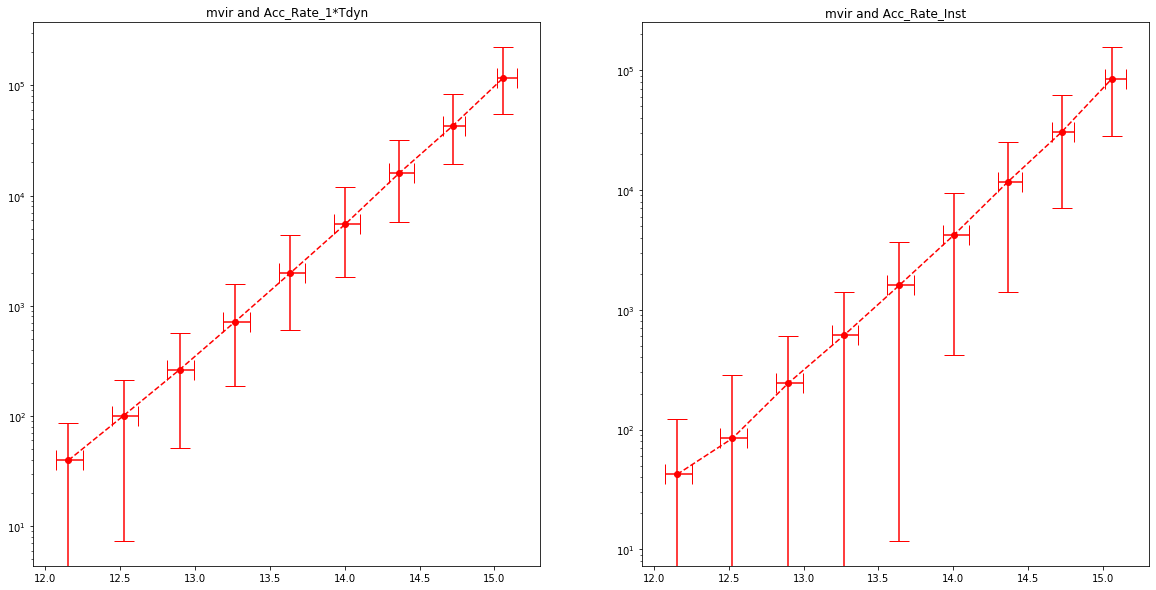

In [89]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

scatter_binning(np.log10(cat['mvir']), cat['Acc_Rate_1*Tdyn'], title='mvir and Acc_Rate_1*Tdyn' ,ax=axs[0])
axs[0].set_yscale('log')

scatter_binning(np.log10(cat['mvir']), cat['Acc_Rate_Inst'], title='mvir and Acc_Rate_Inst', ax=axs[1])
axs[1].set_yscale('log')
# scatter_binning(np.log10(cat['mvir']), np.log10(cat['Acc_Rate_1*Tdyn']) )

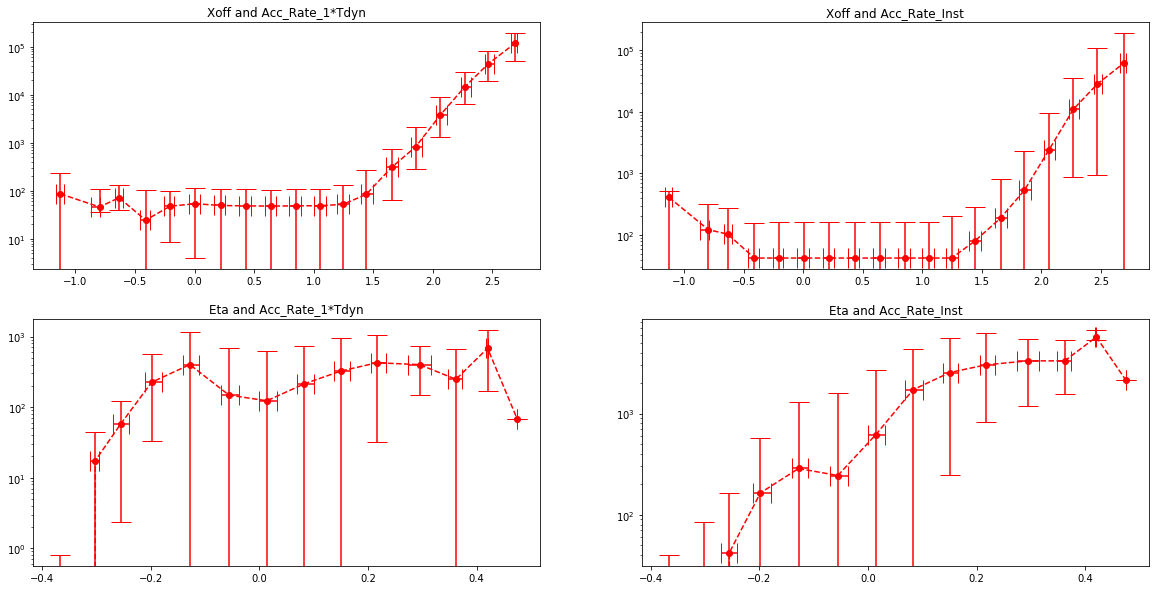

In [98]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axes = axs.flatten()
scatter_binning(np.log10(cat['Xoff']), cat['Acc_Rate_1*Tdyn'], title='Xoff and Acc_Rate_1*Tdyn' ,ax=axes[0], nxbins=20)
axes[0].set_yscale('log')

scatter_binning(np.log10(cat['Xoff']), cat['Acc_Rate_Inst'], title='Xoff and Acc_Rate_Inst', ax=axes[1], nxbins=20)
axes[1].set_yscale('log')

scatter_binning(np.log10(cat['T/|U|']), cat['Acc_Rate_1*Tdyn'], title='Eta and Acc_Rate_1*Tdyn' ,ax=axes[2], nxbins=15)
axes[2].set_yscale('log')

scatter_binning(np.log10(cat['T/|U|']), cat['Acc_Rate_Inst'], title='Eta and Acc_Rate_Inst', ax=axes[3], nxbins=15)
axes[3].set_yscale('log')
# scatter_binning(np.log10(cat['mvir']), np.log10(cat['Acc_Rate_1*Tdyn']) )

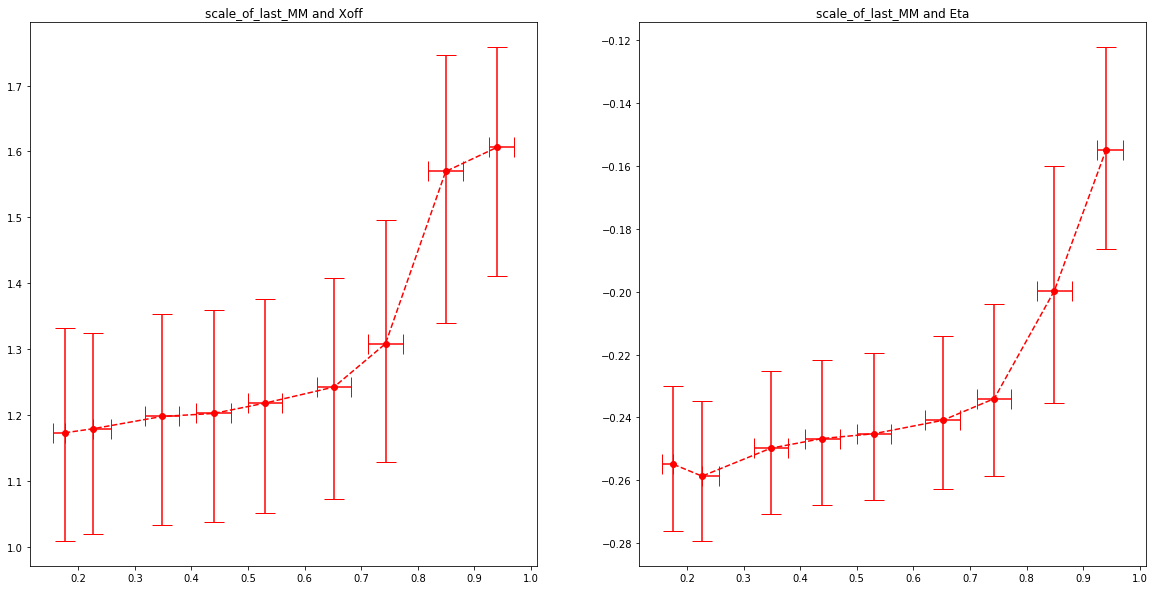

In [24]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
axes = axs.flatten()

scatter_binning( cat['scale_of_last_MM'], np.log10(cat['Xoff']), title='scale_of_last_MM and Xoff' ,ax=axes[0], nxbins=10)

scatter_binning( cat['scale_of_last_MM'], np.log10(cat['T/|U|']), title='scale_of_last_MM and Eta' ,ax=axes[1], nxbins=10)


In [ ]:
#ToDo: 
    #look at statistical errors of these correlations? 
    #need a way of identifying outliers of one parameters and obtaining the halo id? 
    #framework for making all this preprocessing really easy and under-the-hood. 
    # maybe try to look at relaxed halos or dynamical properties? 